In [ ]:
!pip install -U xenonpy rdkit deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.2/809.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 18.

In [ ]:
!git clone https://github.com/hodakamori/ml-tutorial.git

Cloning into 'ml-tutorial'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 100 (delta 30), reused 82 (delta 15), pack-reused 0
Receiving objects: 100% (100/100), 12.69 MiB | 17.32 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
delaney_df = pd.read_csv("ml-tutorial/data/delaney-mordred.csv")
X_dln = delaney_df.loc[:, delaney_df.columns.str.startswith("mordred_")]
y_dln = delaney_df["logS"]
X_dln_train, X_dln_test, y_dln_train, y_dln_test = train_test_split(X_dln, y_dln, test_size=0.2, random_state=42)

In [ ]:
from xenonpy.model.training.dataset import ArrayDataset
from torch.utils.data import DataLoader
train_dataset = DataLoader(ArrayDataset(X_dln_train, y_dln_train), shuffle=True, batch_size=100)
val_dataset = DataLoader(ArrayDataset(X_dln_test, y_dln_test), batch_size=1000)

In [ ]:
from xenonpy.model import SequentialLinear, LinearLayer
model = SequentialLinear(X_dln.shape[1], 1, h_neurons=(0.8, 0.7, 0.6))

In [ ]:
from xenonpy.model.training import Trainer, MSELoss, Adam
from xenonpy.model.training.extension import Validator, TensorConverter
from xenonpy.model.utils import regression_metrics
trainer = Trainer(
    model=model,
    optimizer=Adam(lr=0.01),
    loss_func=MSELoss()
).extend(
    TensorConverter(),
    Validator(metrics_func=regression_metrics, early_stopping=30, trace_order=5, mae=0.0, pearsonr=1.0),
)

In [ ]:
def make_name(model):
    name = []
    for n, m in model.named_children():
        if 'layer_' in n:
            name.append(str(m.linear.in_features))
        else:
            name.append(str(m.in_features))
            name.append(str(m.out_features))
    return '-'.join(name)

In [ ]:
from xenonpy.model.training.extension import Persist
model_name = make_name(model)
persist = Persist(
    model_name,
    # -^- required -^-

    # -v- optional -v-
    increment=False,
    sync_training_step=True,
    author='Hodaka Mori',
    email='email',
    dataset='delaney',
)
_ = trainer.extend(persist)

In [ ]:
import torch
trainer.fit(
    x_train=torch.tensor(X_dln_train.values, dtype=torch.float),
    y_train=torch.tensor(y_dln_train.values.reshape(-1, 1), dtype=torch.float),
    x_val=torch.tensor(X_dln_test.values, dtype=torch.float),
    y_val=torch.tensor(y_dln_test.values.reshape(-1, 1), dtype=torch.float),
    epochs=100
)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

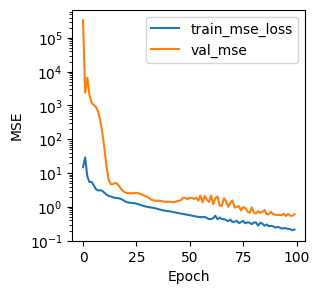

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(3, 3))
trainer.training_info.plot(y=['train_mse_loss', 'val_mse'], ax=ax)
plt.yscale("log")
plt.ylabel("MSE")
plt.xlabel("Epoch")

Text(0.5, 1.0, 'delaney, MLP')

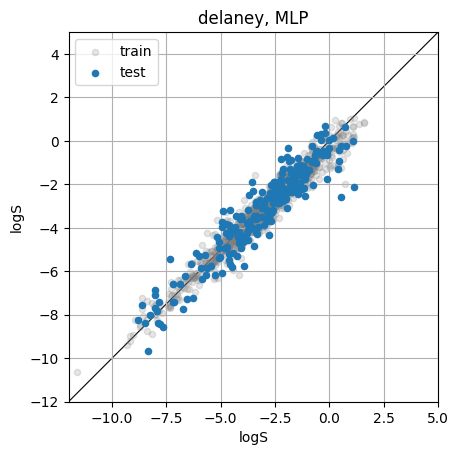

In [ ]:
y_test_pred, y_test = trainer.predict(dataset=val_dataset, checkpoint='pearsonr_1')
y_train_pred, y_train = trainer.predict(dataset=train_dataset, checkpoint='pearsonr_1')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_train, y_train_pred, label="train", color="tab:gray", alpha=0.2, s=20, zorder=1)
ax.scatter(y_test, y_test_pred, label="test", s=20, zorder=2)
ax.plot([-12, 5],[-12, 5], color="black", linewidth=0.8, zorder=0)
ax.set_ylim(-12, 5)
ax.set_xlim(-12, 5)
ax.set_aspect("equal")
ax.set_xlabel("logS")
ax.set_ylabel("logS")
ax.grid(True)
ax.legend()
ax.set_title("delaney, MLP")


In [ ]:
persist()

In [ ]:
trainer = Trainer.load(from_="/content/1613-1291-1130-968-1")
trainer

<ipython-input-16-ed48986072fd>:1: DeprecationWarning: Call to deprecated class method load. (will be removed in v1.0.0, please use `Trainer.from_checker` instead)
  trainer = Trainer.load(from_="/content/1613-1291-1130-968-1")


Trainer(cuda=device(type='cpu'),
        model=SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=1613, out_features=1291, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (normalizer): BatchNorm1d(1291, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=1291, out_featu...
    (normalizer): BatchNorm1d(1130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=1130, out_features=968, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (normalizer): BatchNorm1d(968, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (output): Linear(in_features=968, out_features=1, bias=True)
))

In [ ]:
from xenonpy.descriptor import FrozenFeaturizer
ff = FrozenFeaturizer(model=trainer.model)
ff

FrozenFeaturizer(model=SequentialLinear(
  (layer_0): LinearLayer(
    (linear): Linear(in_features=1613, out_features=1291, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (normalizer): BatchNorm1d(1291, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_1): LinearLayer(
    (linear): Linear(in_features=1291, out_features=1130, bias=T...
    (normalizer): BatchNorm1d(1130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (layer_2): LinearLayer(
    (linear): Linear(in_features=1130, out_features=968, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (normalizer): BatchNorm1d(968, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (output): Linear(in_features=968, out_features=1, bias=True)
))

In [ ]:
freesolv_df = pd.read_csv("./ml-tutorial/data/freesolv.csv")

In [ ]:
y_fs = freesolv_df.iloc[:, 3]
smiles = freesolv_df.loc[:, " SMILES"]

In [ ]:
import deepchem as dc
featurizer = dc.feat.MordredDescriptors(ignore_3D=True)
X_mordred = featurizer.featurize(smiles)
X_mordred = pd.DataFrame(X_mordred)
X_mordred

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,0.0,0.0,0.0,0.0,10.472136,2.000000,4.000000,10.472136,1.163571,3.007971,...,7.739359,34.994205,130.099380,5.656495,110.0,7.0,32.0,31.0,4.361111,2.416667
1,0.0,0.0,0.0,0.0,5.464102,1.732051,3.464102,5.464102,1.092820,2.390167,...,6.192362,25.583106,74.073165,4.938211,20.0,2.0,14.0,12.0,2.750000,1.500000
2,0.0,0.0,0.0,0.0,22.633601,2.437103,4.874207,22.633601,1.257422,3.814249,...,9.916354,51.395631,357.844416,16.265655,577.0,31.0,94.0,112.0,7.888889,3.916667
3,0.0,0.0,0.0,1.0,8.720566,2.101003,4.202006,8.720566,1.245795,2.844305,...,8.124151,33.544698,99.104799,4.955240,42.0,5.0,30.0,31.0,2.361111,1.666667
4,0.0,0.0,0.0,0.0,11.384646,2.148961,4.297922,11.384646,1.264961,3.080020,...,8.379998,36.722228,122.036779,8.135785,94.0,8.0,38.0,40.0,2.861111,2.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,0.0,0.0,0.0,0.0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,...,5.509388,22.328143,95.953355,15.992226,10.0,1.0,10.0,8.0,2.500000,1.250000
638,0.0,0.0,0.0,0.0,11.189957,2.193993,4.387987,11.189957,1.243329,3.089765,...,8.590258,37.289972,120.093900,5.718757,90.0,9.0,40.0,43.0,3.472222,2.166667
639,0.0,0.0,0.0,0.0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,4.174387,17.310771,107.957462,13.494683,4.0,0.0,6.0,4.0,2.250000,1.000000
640,0.0,0.0,0.0,0.0,6.828427,2.000000,4.000000,6.828427,0.975490,2.765108,...,7.655864,32.211905,118.081621,5.622934,48.0,4.0,26.0,24.0,4.472222,1.666667


In [ ]:
X_neural = ff.transform(X_mordred, depth=2, return_type='df')
X_neural_train, X_neural_test, y_neural_train, y_neural_test = train_test_split(X_neural, y_fs, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_neural_train, y_neural_train)
y_neural_test_pred = rf.predict(X_neural_test)
y_neural_train_pred = rf.predict(X_neural_train)

In [ ]:
X_mordred_train, X_mordred_test, y_mordred_train, y_mordred_test = train_test_split(X_mordred, y_fs, test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_mordred_train, y_mordred_train)
y_mordred_test_pred = rf.predict(X_mordred_test)
y_mordred_train_pred = rf.predict(X_mordred_train)

In [ ]:
def parity_plot(ax, title, y_train, y_train_pred, y_test, y_test_pred):
  ax.scatter(y_train, y_train_pred, label="train", color="tab:gray", alpha=0.2, s=20, zorder=1)
  ax.scatter(y_test, y_test_pred, label="test", s=20, zorder=2)
  ax.plot([-30, 5],[-30, 5], color="black", linewidth=0.8, zorder=0)
  ax.set_ylim(-30, 5)
  ax.set_xlim(-30, 5)
  ax.set_aspect("equal")
  ax.set_xlabel(r"$\Delta G$ (kcal/mol)")
  ax.set_ylabel(r"$\Delta G$ (kcal/mol)")
  ax.grid(True)
  ax.legend()
  ax.set_title(title)

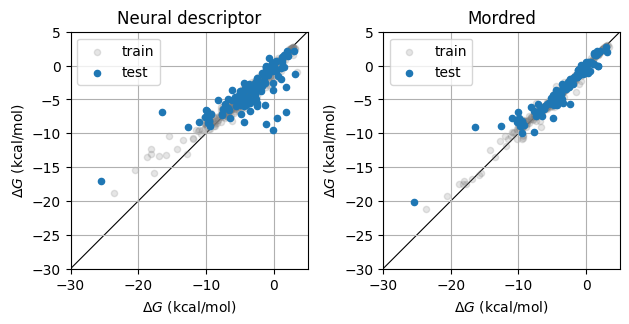

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
parity_plot(
    ax=ax,
    title="Neural descriptor",
    y_train=y_neural_train,
    y_train_pred=y_neural_train_pred,
    y_test=y_neural_test,
    y_test_pred=y_neural_test_pred,
)

ax = fig.add_subplot(1, 2, 2)
parity_plot(
    ax=ax,
    title="Mordred",
    y_train=y_mordred_train,
    y_train_pred=y_mordred_train_pred,
    y_test=y_mordred_test,
    y_test_pred=y_mordred_test_pred,
)

plt.tight_layout()